In [1]:
# Install Required Packages
!pip install -q arxiv sentence_transformers rank_bm25 faiss-cpu contractions nltk pymupdf

# Fetch ArXiv Papers
import arxiv, json, os

def fetch_arxiv_papers(topics=None, per_topic_results=500):
    if topics is None:
        print("You can customize what kind of papers to retrieve.")
        user_input = input("Enter topics separated by commas (e.g., machine learning, biology, medicine): ")
        topics = [t.strip() for t in user_input.split(',') if t.strip()]
    client = arxiv.Client(page_size=25, delay_seconds=3.0)
    results = []
    for t in topics:
        print(f"Fetching papers for topic: {t}")
        search = arxiv.Search(query=t, max_results=per_topic_results, sort_by=arxiv.SortCriterion.Relevance)
        for res in client.results(search):
            results.append({
                "id": res.get_short_id(),
                "title": res.title,
                "summary": res.summary,
                "authors": [a.name for a in res.authors],
                "published": str(res.published)
            })
    os.makedirs("data", exist_ok=True)
    with open("data/arxiv_raw.json", "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)
    print(f"Total papers saved: {len(results)}")

fetch_arxiv_papers()

# Text Cleaning
import re, nltk, contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = contractions.fix(text.lower())
    text = re.sub(r'http\S+|[@#<>/]|[^\w\s]|\d+', '', text)
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words])

def load_clean():
    with open("data/arxiv_raw.json", "r", encoding="utf-8") as f:
        data = json.load(f)
    return [clean_text(p['title'] + ' ' + p['summary']) for p in data]

docs = load_clean()

# Embedding + FAISS Index
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

os.makedirs("embeddings", exist_ok=True)
model = SentenceTransformer('all-MiniLM-L6-v2')
vecs = model.encode(docs, show_progress_bar=True)

index = faiss.IndexFlatL2(vecs.shape[1])
index.add(np.array(vecs))
faiss.write_index(index, "embeddings/faiss.index")

# Query Expansion using FLAN-T5
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

tok = AutoTokenizer.from_pretrained("google/flan-t5-base")
model_t5 = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
expander = pipeline("text2text-generation", model=model_t5, tokenizer=tok)

def expand_query(q):
    prompt = f"Expand this academic search query: {q}"
    return expander(prompt, max_length=50, do_sample=False)[0]["generated_text"].strip()

# Hybrid Search (BM25 + FAISS)
from rank_bm25 import BM25Okapi
import pickle

os.makedirs("bm25", exist_ok=True)
toks = [d.split() for d in docs]
bm = BM25Okapi(toks)
with open("bm25/bm25.pkl", "wb") as f:
    pickle.dump(bm, f)

def hybrid_search(q, top_k=5):
    q_exp = expand_query(q)
    q_vec = model.encode([q_exp])
    _, f_ids = index.search(np.array(q_vec), top_k)
    f_res = [docs[i] for i in f_ids[0]]
    b_scores = bm.get_scores(q_exp.split())
    b_ids = np.argsort(b_scores)[::-1][:top_k]
    b_res = [docs[i] for i in b_ids]
    combined = []
    seen = set()
    for d in f_res + b_res:
        if d not in seen:
            combined.append(d)
            seen.add(d)
    return combined

# Semantic Re-Ranking
from sentence_transformers import CrossEncoder
re_ranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def semantic_rerank(q, d_list, top_k=5):
    pairs = [(q, d) for d in d_list]
    scores = re_ranker.predict(pairs)
    ranked = sorted(zip(d_list, scores), key=lambda x: x[1], reverse=True)
    for i, (d, s) in enumerate(ranked[:top_k]):
        print(f"\nRank {i+1} | Score: {s:.4f}\n{d[:300]}...\n")
    return [d for d, _ in ranked[:top_k]]

# Evaluation Metrics
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_cosine(q, top_k=5):
    q_exp = expand_query(q)
    q_vec = model.encode([q_exp])
    d_vecs = model.encode(docs)
    scores = cosine_similarity(q_vec, d_vecs)[0]
    top_ids = np.argsort(scores)[::-1][:top_k]
    for i, idx in enumerate(top_ids):
        print(f"\nRank {i+1} | Score: {scores[idx]:.4f}\n{docs[idx][:300]}...\n")

# Metrics: Precision, MAP, nDCG

def precision_at_k(y_true, k):
    return sum(y_true[:k]) / k

def average_precision(y_true):
    ap, rel = 0.0, 0
    for i, r in enumerate(y_true):
        if r:
            rel += 1
            ap += rel / (i + 1)
    return ap / max(1, sum(y_true))

def dcg_at_k(relevance, k):
    return sum([rel / np.log2(i + 2) for i, rel in enumerate(relevance[:k])])

def ndcg_at_k(y_true, k):
    dcg = dcg_at_k(y_true, k)
    idcg = dcg_at_k(sorted(y_true, reverse=True), k)
    return dcg / idcg if idcg else 0

# Run CORAG Demo
q = input("Enter your research query: ")
print("\nExpanded Query:", expand_query(q))
r_docs = hybrid_search(q, top_k=10)
semantic_rerank(q, r_docs, top_k=5)

# Example Evaluation
labels = [1, 1, 0, 1, 0]
print("\nPrecision@3:", precision_at_k(labels, 3))
print("MAP:", average_precision(labels))
print("nDCG@5:", ndcg_at_k(labels, 5))


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Enter your research query: protein structure using machine learning

Expanded Query: protein structure using machine learning

Rank 1 | Score: 4.7592
learning engineer protein flexibility generative machine learning model increasingly used design novel protein therapeutic biotechnological application however current method mostly focus design protein fixed backbone structure lead limited ability account protein flexibility one crucial property pr...


Rank 2 | Score: 4.4428
sbsmpro support biosequence machine protein protein play pivotal role biological system use machine learning algorithm protein classification assist even guide biological experiment offering crucial insight biotechnological application introduce support biosequence machine protein sbsmpro model purp...


Rank 3 | Score: 2.1482
artificial intelligenceaided protein engineering topological data analysis deep protein language model protein engineering emerging field biotechnology potential revolutionize various area ant

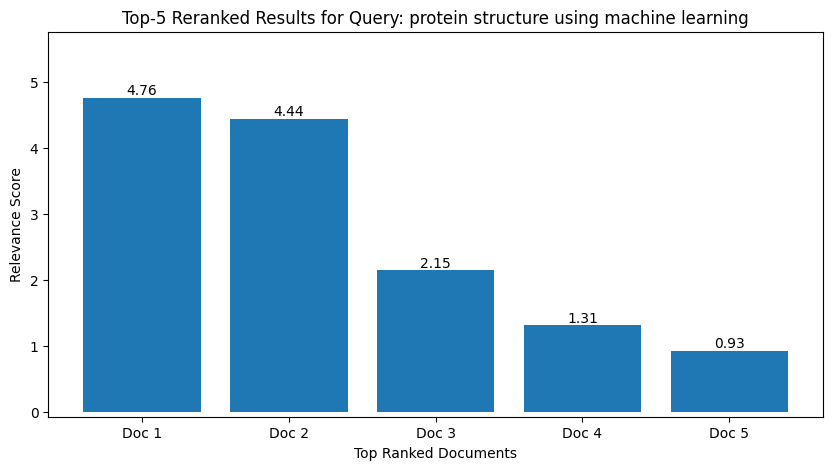

In [2]:
import matplotlib.pyplot as plt

def plot_reranked_results(q, docs, top_k=5):
    pairs = [(q, d) for d in docs]
    scores = re_ranker.predict(pairs)
    ranked = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)[:top_k]

    labels = [f"Doc {i+1}" for i in range(len(ranked))]
    values = [s for _, s in ranked]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(labels, values)
    plt.xlabel("Top Ranked Documents")
    plt.ylabel("Relevance Score")
    plt.title(f"Top-{top_k} Reranked Results for Query: {q}")
    plt.ylim(min(values) - 1, max(values) + 1)

    for bar, score in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{score:.2f}", ha='center', va='bottom')

    plt.show()

# Example call
plot_reranked_results(q, r_docs, top_k=5)

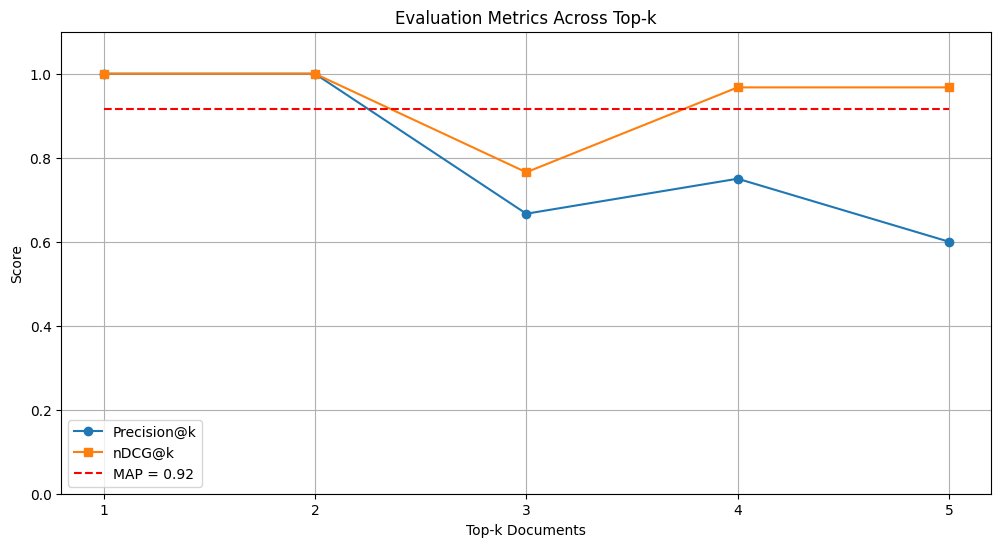

In [3]:
def plot_metrics(lbls):
    ks = [1, 2, 3, 4, 5]
    prec = [precision_at_k(lbls, k) for k in ks]
    ap = average_precision(lbls)
    ndcg = [ndcg_at_k(lbls, k) for k in ks]

    plt.figure(figsize=(12, 6))
    plt.plot(ks, prec, marker='o', label='Precision@k')
    plt.plot(ks, ndcg, marker='s', label='nDCG@k')
    plt.hlines(y=ap, xmin=1, xmax=5, colors='red', linestyles='dashed', label=f'MAP = {ap:.2f}')

    plt.title("Evaluation Metrics Across Top-k")
    plt.xlabel("Top-k Documents")
    plt.ylabel("Score")
    plt.xticks(ks)
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call
plot_metrics(labels)

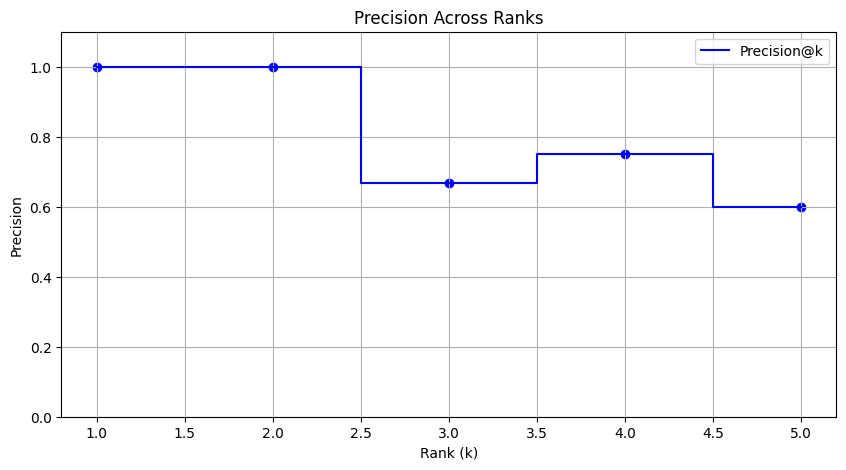

In [11]:
def plot_precision_curve(lbls):
    ks = list(range(1, len(lbls) + 1))
    prec = [precision_at_k(lbls, k) for k in ks]

    plt.figure(figsize=(10, 5))
    plt.step(ks, prec, where='mid', label='Precision@k', color='blue')
    plt.scatter(ks, prec, color='blue')

    plt.title("Precision vs Rank")
    plt.xlabel("Rank (k)")
    plt.ylabel("Precision")
    plt.ylim(0, 1.1)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call
plot_precision_curve(labels)

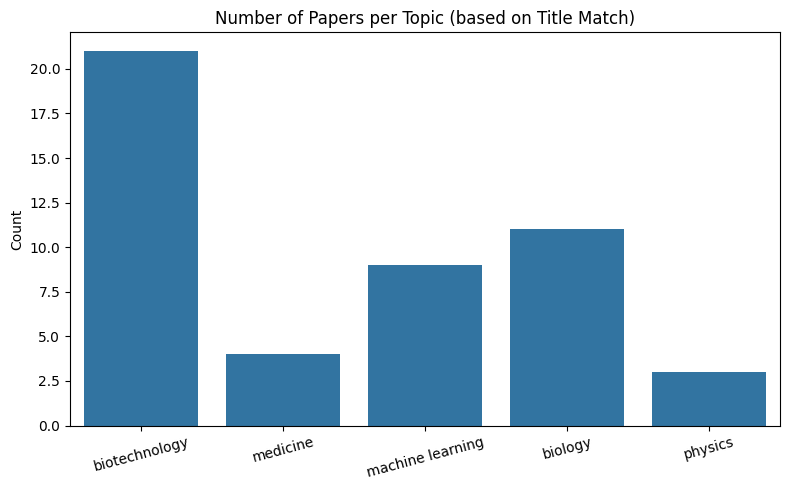

In [12]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load raw paper data
with open("data/arxiv_raw.json", "r", encoding="utf-8") as f:
    papers = json.load(f)

# Count papers per topic using keywords in titles
t_count = Counter()
topics = ['machine learning', 'biology', 'biotechnology', 'medicine', 'physics']
for p in papers:
    title = p['title'].lower()
    for t in topics:
        if t in title:
            t_count[t] += 1

# Plot topic distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(t_count.keys()), y=list(t_count.values()))
plt.title("Paper Count per Topic (by Title Keywords)")
plt.ylabel("Document Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

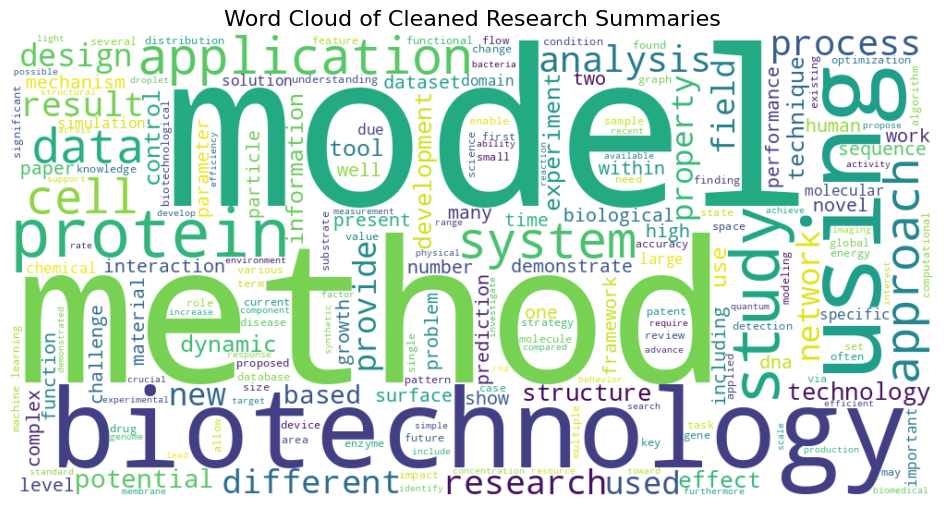

In [13]:
text = " ".join(docs)
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Research Summaries", fontsize=16)
plt.show()


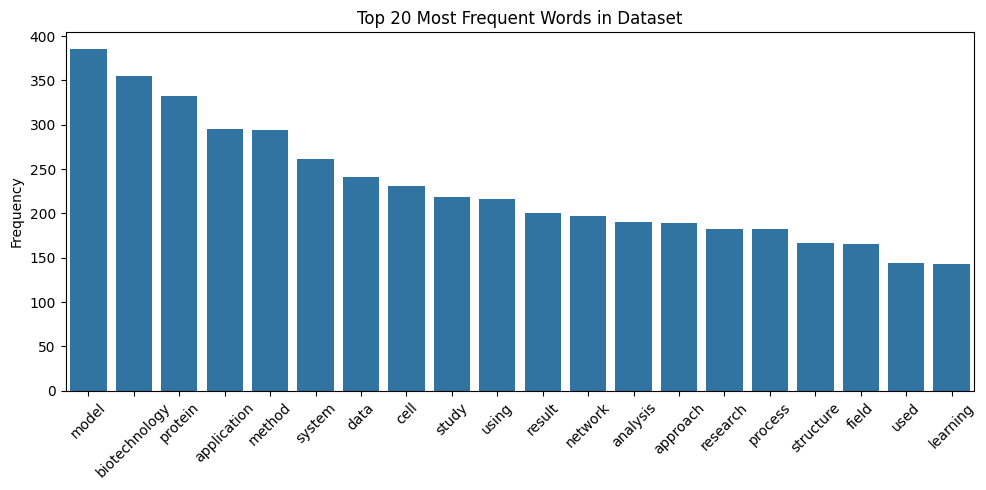

In [14]:
# Combine all cleaned text
all_words = " ".join(docs).split()
word_freq = Counter(all_words).most_common(20)

# Plot
words, freqs = zip(*word_freq)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(freqs))
plt.title("Top 20 Most Frequent Words in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
